### CITS5508 labsheet 5
**Chenxin Hu 22961779**

In this labsheet I'm going to 

1. load the cifar data, split the data into train set and validation set using a ratio 85 - 15.

2. develop a function to display 20 data randomly selected from the set and their class.

3. implemente an MLP classifier, fine tune it and evaluate the model.

4. implemente an CNN classifier, fine tune it and evaluate the model.

5. compare the CNN model and MLP model, summarizing their differences.

#### Import Necessary Libs & Classes

In [106]:
import os
from data_loader import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
from model_profiler import model_profiler



#### Data preparation and visualisation

In this part I split the data to training set and validation set using a ratio 85:15.

Then a function for displaying 20 random sampled images from the set and their class name was implemented.

The function was called 3 times for training set, validation set and test set.

In [107]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_ori, y_ori = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)
x_train,x_validation,y_train,y_validation = train_test_split(X_ori, y_ori, test_size=0.15, random_state=0)

For train set: 


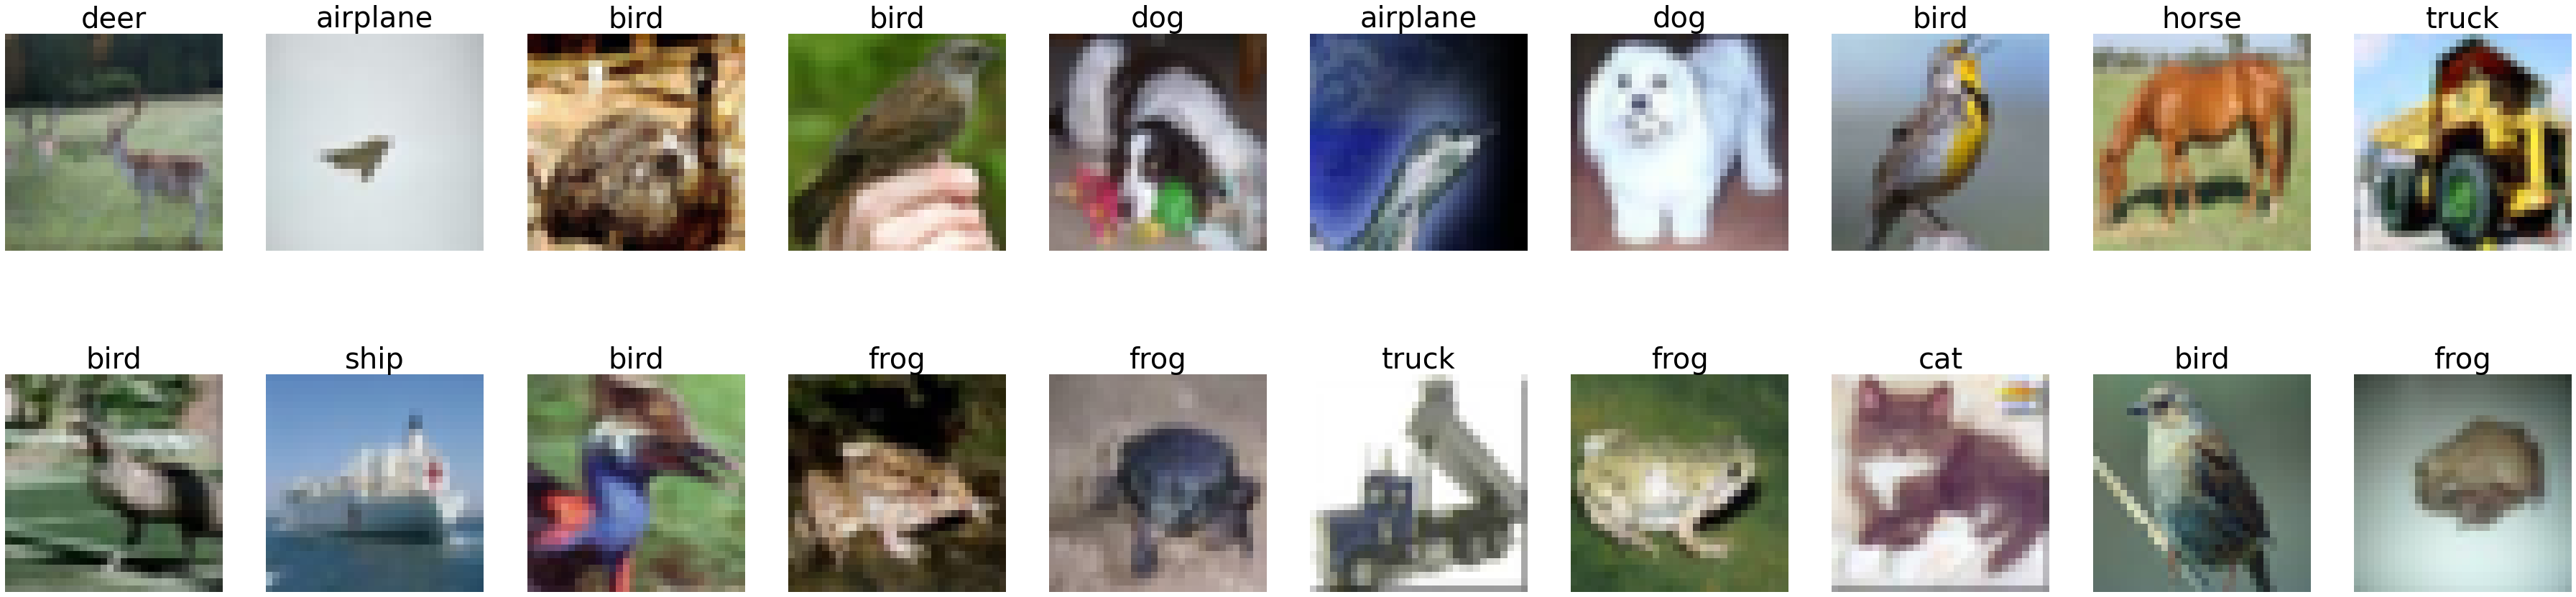

For validation set: 


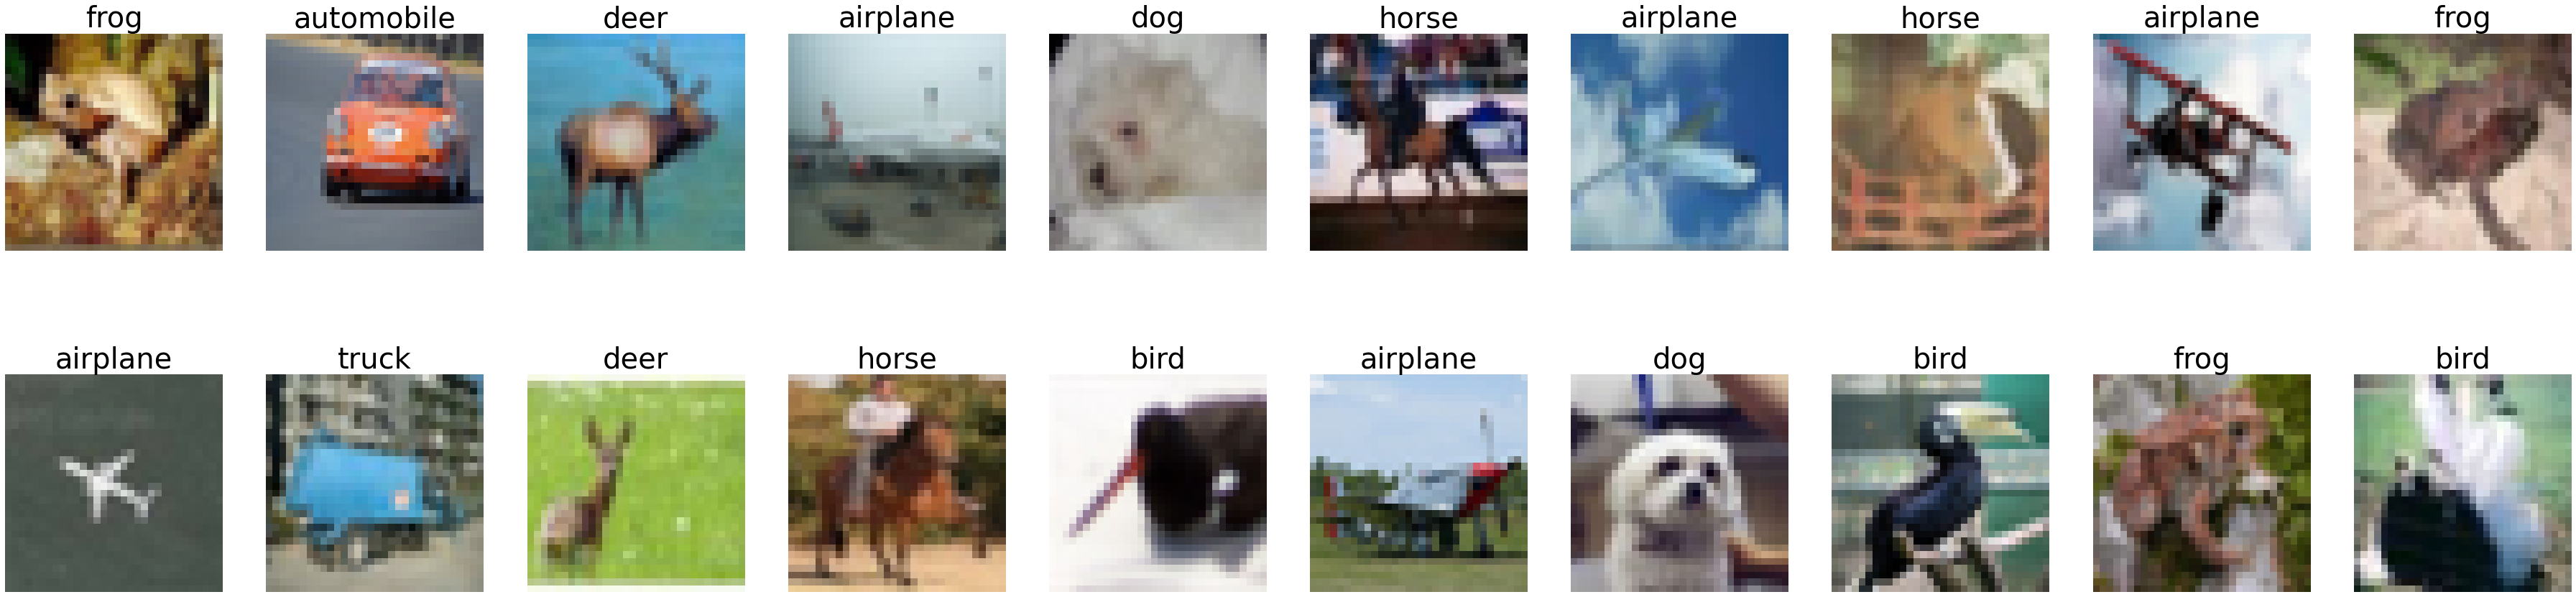

For test set: 


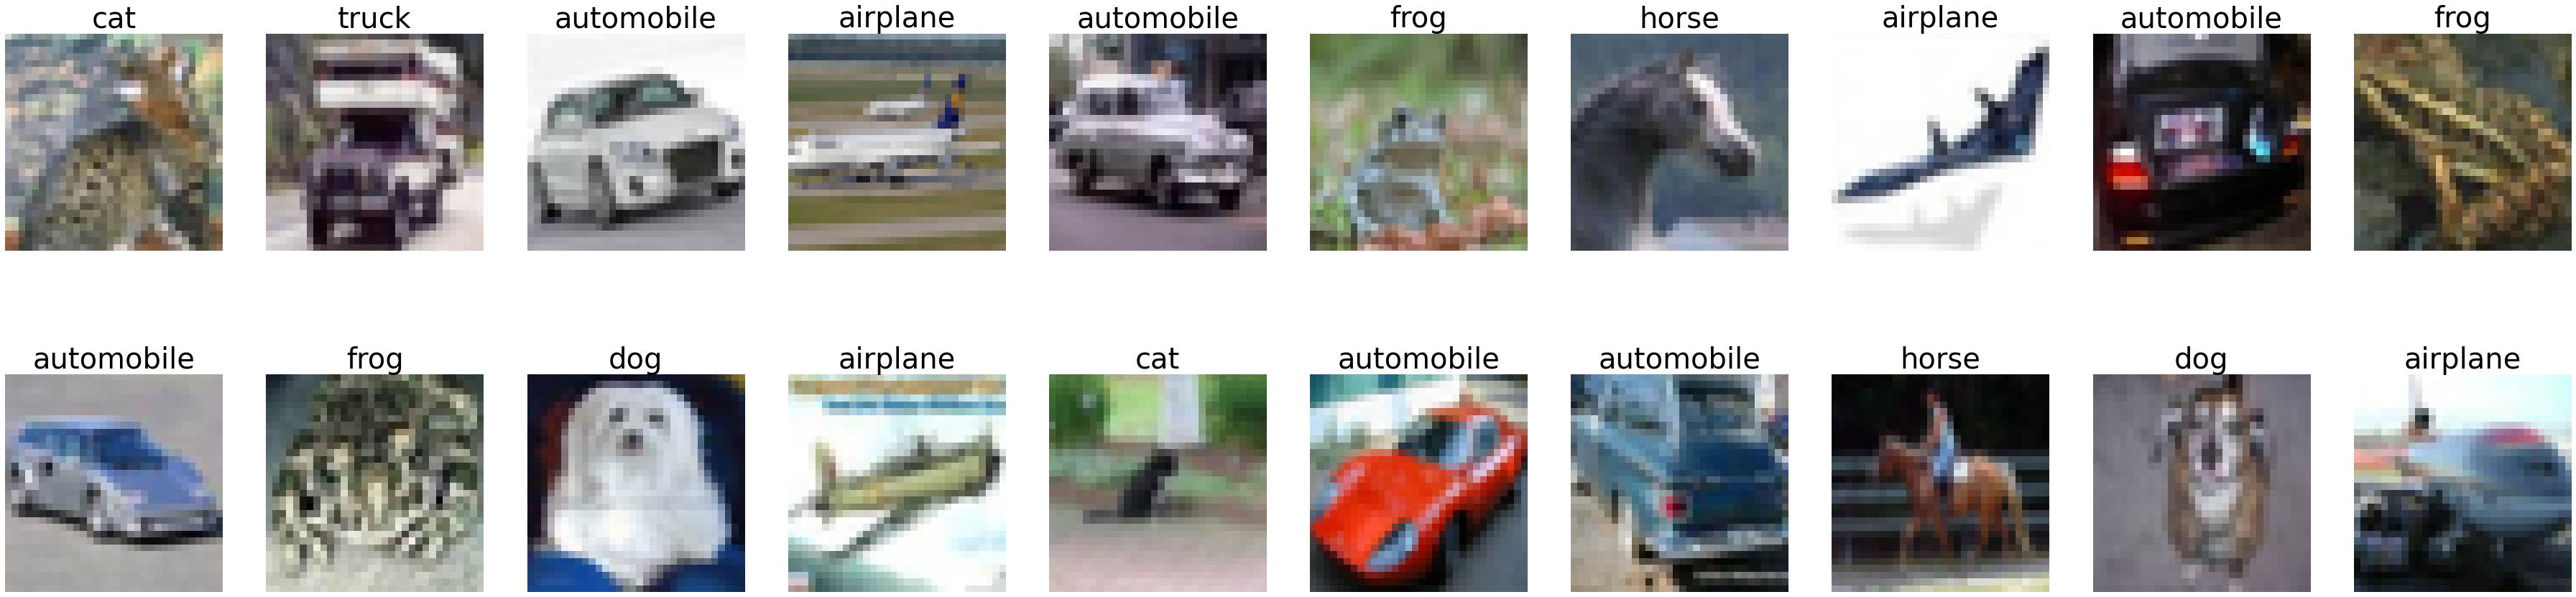

In [108]:
# define a function to display 20 images randomly selected from the set and their class label.
# apply 3 times for train set, validation set and test set.
def displaySampleImage(x_set,y_set):
    plt.figure(figsize=(64,16))
    nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    rdIndex=random.sample(range(0,len(x_set)-1),20)
    plotNum=0
    for i in rdIndex:
        plt.subplot(2,10,plotNum+1)
        plt.axis('off')
        plt.title(nameList[y_set[i]],fontsize=40)
        plt.imshow(x_set[i])
        plotNum=plotNum+1
    plt.show()

print("For train set: ")
displaySampleImage(x_train,y_train)
print("For validation set: ")
displaySampleImage(x_validation,y_validation)
print("For test set: ")
displaySampleImage(X_test,y_test)


#### MLP (a) Hyperparameters

In this part, three possible settings for two hyperparameters: connection weight initialisation & dropout rate were examined using grid search

An early stopping was incorporated and the the patience was set to 10 due to I only train one model for 50 ephochs in grid serach, baseline was set to 0.2 to filter the hyperparametering settings with too low the accuracy.

The early stopping callback will monitoring the accuracy of each ephoch and stops the model fitting when accuracy was not improved in a patience interval upon the baseline.

**Fine tune procedure**
```
best_acc=0
for drop_out in [0.2,0.5,0.8]:
  for init in ["random_normal","random_uniform","variance_scaling"]:
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    model.add(keras.layers.Dense(300,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(200,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(100,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(10,activation="softmax"))# 1 neurons per class, total 10 classes
    model.compile(loss="sparse_categorical_crossentropy",
          optimizer="sgd",
          metrics=['accuracy'])
    model.fit(x_train,y_train,epochs=50,validation_data=(x_validation,y_validation),
          callbacks=[EarlyStopping(
              patience=10,
              min_delta=0.05,
              baseline=0.2,
              mode='max',
              monitor='val_accuracy',
              restore_best_weights=True,
              verbose=1)])
    scores=model.evaluate(X_test,y_test)
    if scores[1]>best_acc:
      best_acc=scores[1]
      best_loss=scores[0]
      best_para={'drop_out':drop_out,'init':init}
print(best_acc)
print(best_loss)
print(best_para)
```

#### MLP (b) Architecture & MLP(c) Training and Testing

The model has 3 hidden layers, and each hidden layers have fewer neurons than the input layer.

The dropout rate was set to 0.2 and use random_normal initializer as the fine-tune procedure shows

Information of the model was displayed using *model.summary()*

Then the model was trained for 1 ephoch if it is loaded from local file or 100 ephoches if there's no local file exists.

The model was tested usinng test set and give a loss and accuracy result.

I use sgd as optimizer cause sgd is more suitable for large data set 

And for loss function I use sparse_categorical_crossentropy because it accepts decrete values which classification work would produce.

In [109]:
# load exsiting model or train a new model
if os.path.exists('./Hu_Chenxin-MLP'):
    mlp_model=keras.models.load_model("Hu_Chenxin-MLP")
    mlp_model.summary()
    mlp_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    history=mlp_model.fit(x_train,y_train,epochs=1,validation_data=(x_validation,y_validation))

else:
    mlp_model = keras.models.Sequential()
    mlp_model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    mlp_model.add(keras.layers.Dense(300,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(200,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(100,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(10,activation="softmax"))# 1 neurons per class, total 10 classes
    mlp_model.summary()
    mlp_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    history=mlp_model.fit(x_train,y_train,epochs=100,validation_data=(x_validation,y_validation),
        callbacks=[EarlyStopping(
        patience=10,
        min_delta=0.01,
        baseline=0.2,
        mode='max',
        monitor='val_accuracy',
        restore_best_weights=True,
        verbose=1)])
    mlp_model.save("Hu_Chenxin-MLP")  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               921900    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

#### MLP (d) Classification results

In this part, I'll investgate the classification performance in accuracy, F1 score and precision per class.

A confusion matrices was computed and draw

And I'll anlyze the model complexity and computation time.

From the result we can see that the mlp only have a mean accuracy of 0.456 on test set, compared with the.

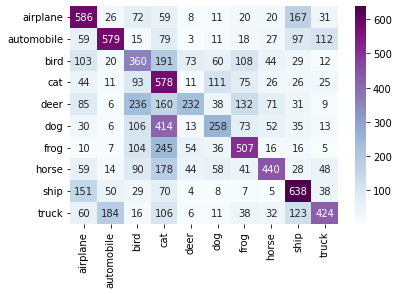

In [110]:
# predict and use the predict result to draw confusion matrices

result = mlp_model.predict(X_test) 
ori_pred = np.argmax(result, axis = 1)
ori_test=y_test
pred=[]
test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(ori_pred)):
    pred.append(nameList[ori_pred[i]])
    test.append(nameList[ori_test[i]])


#print(label)
conf=confusion_matrix(test,pred)
conf_numpy=conf
conf_df=pd.DataFrame(conf_numpy,index=nameList,columns=nameList)
conf_fig = sn.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu") 

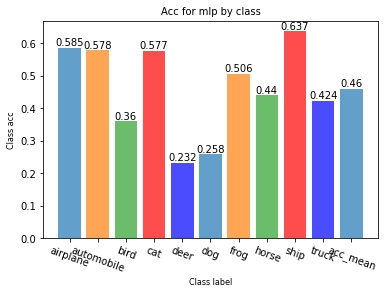

In [111]:
# accuracy by class

acc_list=[]
for i in range(0,10):
    total=1
    right=conf[i][i]
    for j in range(0,10):
        total=total+conf[i][j]
    acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
y_data=acc_list

acc_list = np.array(acc_list)

y_data.append(acc_list.mean())


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for mlp by class", fontdict={'size': 10})
plt.show()

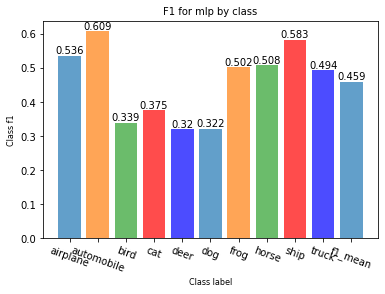

In [112]:
# F1 score by class

precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","f1_mean"]
y_data=f1_list.tolist()
y_data.append(f1_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class f1", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("F1 for mlp by class", fontdict={'size': 10})
plt.show()

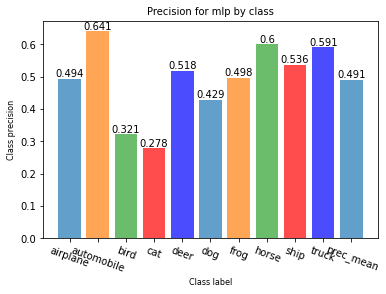

In [113]:
# precision by class
x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","prec_mean"]
y_data=precision_list.tolist()
y_data.append(precision_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class precision", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Precision for mlp by class", fontdict={'size': 10})
plt.show()

In [114]:
# model complexity

Batch_size = 10
profile=model_profiler(mlp_model,Batch_size)
print(profile)


| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0           | BFLOPs  |
| GPU Memory Requirement           | 0.0011        | GB      |
| Model Parameters                 | 1.0032        | Million |
| Memory Required by Model Weights | 3.8269        | MB      |


#### CNN (a) Hyperparameters

In this part, two possible settings for all three hyperparameters were examined using grid serach

An early stopping was incorporated and the the patience was set to 10 due to I only train one model for 50 ephochs in grid serach, baseline was set to 0.2 to filter the hyperparametering settings with too low the accuracy.

The early stopping callback will monitoring the accuracy of each ephoch and stops the model fitting when accuracy was not improved in a patience interval upon the baseline.

**Fine tune procedure**
```
best_acc=0
for k_size in [3,5]:
  for active in ["relu","sigmoid"]:
    for k_num in [64,128]:
      model= keras.models.Sequential([
      keras.layers.Conv2D(k_num,7,activation=active,padding="same",input_shape=[32,32,3]),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(k_num*2,k_size,activation=active,padding="same"),
      keras.layers.Conv2D(k_num*2,k_size,activation=active,padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(k_num*4,k_size,activation=active,padding="same"),
      keras.layers.Conv2D(k_num*4,k_size,activation=active,padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Flatten(),
      keras.layers.Dense(128,kernel_initializer="random_normal",activation=active),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64,kernel_initializer="random_normal",activation=active),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(10,activation="softmax"),
      ])
      model.compile(loss="sparse_categorical_crossentropy",
            optimizer="sgd",
            metrics=['accuracy'])
      model.fit(x_train,y_train,epochs=50,validation_data=(x_validation,y_validation),callbacks=[EarlyStopping(
                patience=10,
                min_delta=0.05,
                baseline=0.2,
                mode='max',
                monitor='val_accuracy',
                restore_best_weights=True,
                verbose=1)])
      scores=model.evaluate(X_test,y_test)
      if scores[1]>best_acc:
        best_acc=scores[1]
        best_loss=scores[0]
        best_para={'k_size':k_size,'active':active,'k_num':k_num}
print(best_acc)
print(best_loss)
print(best_para)
```

#### CNN(b) Architecture & CNN (c) Training and testing

I built a CNN with 2 convolutional layers, pooling layers and batch normalisation using *keras.layers.BatchNormalization()*.

Information of the model was displayed using *summary()*.

From the fine-tune result, I set the layers' k_size as 5 and k_num as 128/256/512 and using active function relu.

I compiled the network using sgd as optimizer and sparse_categorical_crossentropy as loss function.

becaused sgd was more suitable for large data set and loss function sparse_categorical_crossentropy accepts decrete values which classification work would produce.

The model is trained for 1 ephoch if there exists model file, trained for 100 ephoches if there isn't.



In [115]:
# load the model if exists or train a new model

if os.path.exists('./Hu_Chenxin-CNN'):
    cnn_model=keras.models.load_model("Hu_Chenxin-CNN")
    cnn_model.summary()
    cnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    #history=cnn_model.fit(x_train,y_train,epochs=1,validation_data=(x_validation,y_validation))
else:
    cnn_model= keras.models.Sequential([
    keras.layers.Conv2D(128,7,activation="relu",padding="same",input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256,5,activation="relu",padding="same"),
    keras.layers.Conv2D(256,5,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512,5,activation="relu",padding="same"),
    keras.layers.Conv2D(512,5,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu",kernel_initializer="random_normal",),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,activation="relu",kernel_initializer="random_normal",),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10,activation="softmax"),
    ])
    cnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    cnn_model.summary()
    history=cnn_model.fit(x_train,y_train,epochs=100,validation_data=(x_validation,y_validation),
        callbacks=[EarlyStopping(
        patience=10,
        min_delta=0.01,
        baseline=0.2,
        mode='max',
        monitor='val_accuracy',
        restore_best_weights=True,
        verbose=1)])
    cnn_model.save("Hu_Chenxin-CNN")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       18944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       1638656   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 512)        

#### CNN(d) Classification results

In this part, I'll investgate the classification performance in accuracy, F1 score and precision per class.

And I'll anlyze the model complexity and computation time.

In [116]:
# average accuracy
eval=cnn_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

313/313 [==============================] - 116s 371ms/step - loss: 0.9458 - accuracy: 0.7858
loss is: 0.9643010497093201
acc is: 0.7809000015258789


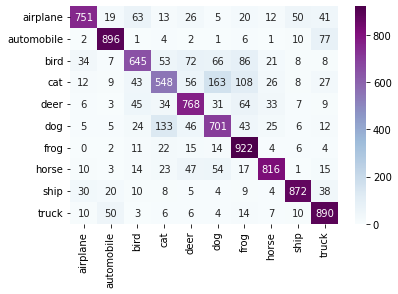

In [117]:
# predict and use the predict result to draw confusion matrices

result = cnn_model.predict(X_test) 
ori_pred = np.argmax(result, axis = 1)
ori_test=y_test
pred=[]
test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(ori_pred)):
    pred.append(nameList[ori_pred[i]])
    test.append(nameList[ori_test[i]])


#print(label)
conf=confusion_matrix(test,pred)
conf_numpy=conf
conf_df=pd.DataFrame(conf_numpy,index=nameList,columns=nameList)
conf_fig = sn.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu") 

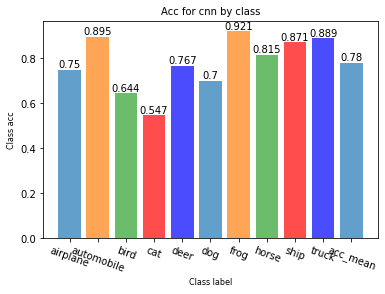

In [118]:
# accuracy by class

acc_list=[]
for i in range(0,10):
    total=1
    right=conf[i][i]
    for j in range(0,10):
        total=total+conf[i][j]
    acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
y_data=acc_list

acc_list = np.array(acc_list)

y_data.append(acc_list.mean())


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for cnn by class", fontdict={'size': 10})
plt.show()

In [119]:
precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)

for i in range(0,10):
    print("For class "+str(nameList[i])+" The F1 score is: "+str(f1_list[i]))
print('The mean F1 score is: ',f1_list.mean())

For class airplane The F1 score is: 0.8075268817204301
For class automobile The F1 score is: 0.8897715988083416
For class bird The F1 score is: 0.6939214631522322
For class cat The F1 score is: 0.5943600867678959
For class deer The F1 score is: 0.7518355359765051
For class dog The F1 score is: 0.6862457170827215
For class frog The F1 score is: 0.8055919615552644
For class horse The F1 score is: 0.8373524884556183
For class ship The F1 score is: 0.8816986855409505
For class truck The F1 score is: 0.8392267798208392
The mean F1 score is:  0.7787531198880798


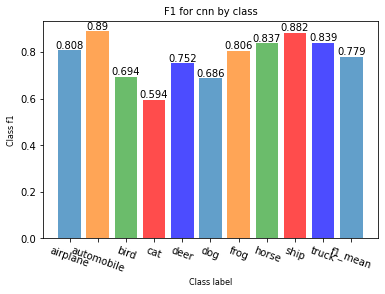

In [120]:
# F1score by class
precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","f1_mean"]
y_data=f1_list.tolist()
y_data.append(f1_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class f1", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("F1 for cnn by class", fontdict={'size': 10})
plt.show()

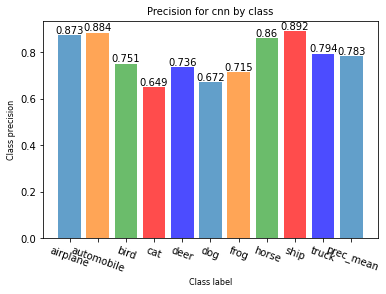

In [121]:
# precision by class
x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","prec_mean"]
y_data=precision_list.tolist()
y_data.append(precision_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class precision", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Precision for cnn by class", fontdict={'size': 10})
plt.show()

In [122]:
# model compleixty

Batch_size = 10
profile=model_profiler(cnn_model,Batch_size)
print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0256        | BFLOPs  |
| GPU Memory Requirement           | 0.0271        | GB      |
| Model Parameters                 | 13.3669       | Million |
| Memory Required by Model Weights | 50.9905       | MB      |


#### MLP & CNN Comparis on & Summary

In this part I compared the accuracy of MLP and CNN models in

1. classification accuracies
2. confusion matrices
3. model's complexity
4. classes where one model worked but the other failed
5. classes where both worked well or failed
6. training time

accuracies
CNN: 0.7237
MLP: 0.5364


time

CNN: 55s per ephoch
MLP: 5s per ephoch

In [123]:
eval=mlp_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

eval=cnn_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.5089 - accuracy: 0.4602
loss is: 1.5088926553726196
acc is: 0.4602000117301941
313/313 [==============================] - 109s 350ms/step - loss: 0.9643 - accuracy: 0.7809
loss is: 0.9643010497093201
acc is: 0.7809000015258789


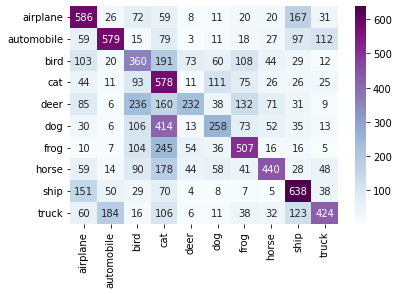

In [124]:
mlp_result = mlp_model.predict(X_test) 
mlp_ori_pred = np.argmax(mlp_result, axis = 1)
mlp_ori_test=y_test
mlp_pred=[]
mlp_test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(mlp_ori_pred)):
    mlp_pred.append(nameList[mlp_ori_pred[i]])
    mlp_test.append(nameList[mlp_ori_test[i]])


#print(label)
mlp_conf=confusion_matrix(mlp_test,mlp_pred)
mlp_conf_df=pd.DataFrame(mlp_conf,index=nameList,columns=nameList)
mlp_conf_fig = sn.heatmap(mlp_conf_df, annot=True, fmt="d", cmap="BuPu") 



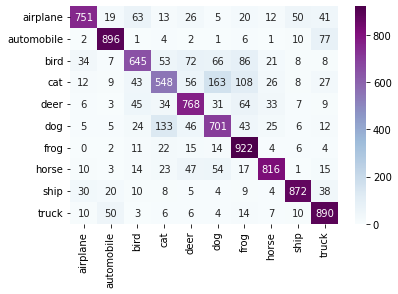

In [125]:
cnn_result = cnn_model.predict(X_test) 
cnn_ori_pred = np.argmax(cnn_result, axis = 1)
cnn_ori_test=y_test
cnn_pred=[]
cnn_test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(cnn_ori_pred)):
    cnn_pred.append(nameList[cnn_ori_pred[i]])
    cnn_test.append(nameList[cnn_ori_test[i]])


#print(label)
cnn_conf=confusion_matrix(cnn_test,cnn_pred)
cnn_conf_df=pd.DataFrame(cnn_conf,index=nameList,columns=nameList)
cnn_conf_fig = sn.heatmap(cnn_conf_df, annot=True, fmt="d", cmap="BuPu") 

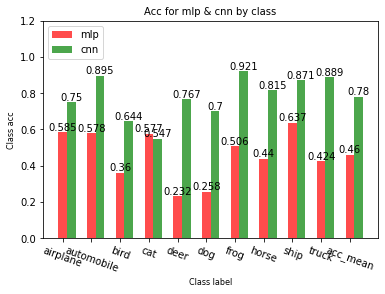

In [126]:
# mlp acc
mlp_acc_list=[]
for i in range(0,10):
    total=1
    right=mlp_conf[i][i]
    for j in range(0,10):
        total=total+mlp_conf[i][j]
    mlp_acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
mlp_y_data=mlp_acc_list

mlp_acc_list = np.array(mlp_acc_list)

mlp_y_data.append(mlp_acc_list.mean())


# cnn acc

cnn_acc_list=[]
for i in range(0,10):
    total=1
    right=cnn_conf[i][i]
    for j in range(0,10):
        total=total+cnn_conf[i][j]
    cnn_acc_list.append(right/total)
cnn_y_data=cnn_acc_list

cnn_acc_list = np.array(cnn_acc_list)

cnn_y_data.append(cnn_acc_list.mean())


bars=plt.bar(x_data, mlp_y_data,color='red',width=0.3,alpha=0.7,label='mlp')
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
bars=plt.bar(np.arange(len(mlp_y_data))+0.3, cnn_y_data,color='green',width=0.3,alpha=0.7,label='cnn')
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for mlp & cnn by class", fontdict={'size': 10})
plt.ylim (0,1.2)
plt.legend(loc='upper left')

plt.show()


In [127]:
Batch_size = 10
profile=model_profiler(mlp_model,Batch_size)
print(profile)
Batch_size = 10
profile=model_profiler(cnn_model,Batch_size)
print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0           | BFLOPs  |
| GPU Memory Requirement           | 0.0011        | GB      |
| Model Parameters                 | 1.0032        | Million |
| Memory Required by Model Weights | 3.8269        | MB      |
| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0256        | BFLOPs  |
| GPU Memory Requirement           | 0.0271        | GB      |
| Model Parameters                 | 13.3669       | Million |
| Memory Required by Model Weights | 50.9905       | MB      |
